In [1]:
%matplotlib inline

import os
import sys
import time
import copy
import random
import tqdm.notebook as tq

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict # https://stackoverflow.com/questions/5900578/how-does-collections-defaultdict-work

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms.functional as TF
import torchvision.models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =',device)

device = cpu


# Load Data

In [2]:
# Define some helper functions

# Classes in the dataset
classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,255]

def pascal_palette():
    '''
    Returns palette (used in 'P' mode of image representation)
    '''
    colors_dict = {
        0: [0, 0, 0],        # 0=background
        1: [128, 0, 0],      # 1=aeroplane
        2: [0, 128, 0],      # 2=bicycle
        3: [128, 128, 0],    # 3=bird
        4: [0, 0, 128],      # 4=boat
        5: [128, 0, 128],    # 5=bottle
        6: [0, 128, 128],    # 6=bus
        7: [128, 128, 128],  # 7=car
        8: [64, 0, 0],       # 8=cat
        9: [192, 0, 0],      # 9=chair
        10: [64, 128, 0],    # 10=cow
        11: [192, 128, 0],   # 11=diningtable
        12: [64, 0, 128],    # 12=dog
        13: [192, 0, 128],   # 13=horse
        14: [64, 128, 128],  # 14=motorbike
        15: [192, 128, 128], # 15=person
        16: [0, 64, 0],      # 16=potted plant
        17: [128, 64, 0],    # 17=sheep
        18: [0, 192, 0],     # 18=sofa
        19: [128, 192, 0],   # 19=train
        20: [0, 64, 128],    # 20=tv/monitor
        255: [224, 224, 192] # 255=void
        }
    palette = []
    for i in np.arange(256):
        if i in colors_dict:
            palette.extend(colors_dict[i])
        else:
            palette.extend([0, 0, 0])
    return palette


def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (K,H,W) where the last dim is a one-hot encoding vector
    0: background
    [1 .. 20] interval: segmented objects, classes [Aeroplane, ..., Tvmonitor]
    255: void category, used for border regions (5px) and to mask difficult objects
    modified from https://www.programmersought.com/article/97425131352/
    """
    mask = np.asanyarray(mask)
    _mask = [mask == i for i in classes]
    return np.array(_mask).astype(np.uint8)


def onehot2mask(onehot):
    """
    Converts onehot representation (K, H, W) to mask representation (H,W)
    """
    _mask = np.argmax(onehot, axis=0).astype(np.uint8)    
    return np.where(_mask==21, 255, _mask)


def onehot2image(onehot, mode = "P"):
    """
    Converts a mask (K, H, W) to (H,W) palette image
    """
    mask = onehot2mask(onehot)
    img = Image.fromarray(mask, 'P')
    palette = pascal_palette()
    img.putpalette(palette)
    if mode == 'RGB':
        img = img.convert('RGB')
    return img


def preview(image, mask, alpha = False):
    '''
    preview function for image and mask
    '''
    # preview side by side
    if alpha == False:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        #fig.suptitle('Horizontally stacked subplots')
        ax1.imshow(image.permute(1, 2, 0))
        ax2.imshow(mask)
    else:
        # transform Tensor to PIL image
        trans = transforms.ToPILImage()
        image_pil=trans(image)
        # mask is in palette mode so change to RGB to blend them together
        mask_rgb=mask.convert('RGB')
        #print(mask_rgb.mode)
        blend_image = Image.blend(image_pil, mask_rgb, alpha=alpha)
        plt.imshow(blend_image)
    plt.show()


def preview_tensor(tensor):
    '''
    plots image tensor

    '''
    plt.imshow(tensor.permute(1, 2, 0))
    plt.show()


def hstack_images(images, space = 10):
    '''
    stacks images horizontally to single image and separates them by space
    '''
    widths, heights = zip(*(i.size for i in images))
    
    total_width = sum(widths) + space*(len(images)-1)
    max_height = max(heights)
    
    new_im = Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0] + space

    return new_im


In [3]:
'''directory = 'input/VOCdevkit/VOC2007/SegmentationClass/'
png_files = []
for dirpath, subdirs, files in os.walk(directory):
    for x in files:
        if x.endswith(".png"):
            png_files.append(os.path.join(dirpath, x))

# find minimum sizes of images in the set
h_min, w_min = 10000, 10000
for file in png_files:
    im = Image.open(file)
    h,w = im.size
    if h < h_min:
        h_min = h
    if w < w_min:
        w_min = w
print(h_min, w_min)'''

'''mask = 'input/VOCdevkit/VOC2007/SegmentationClass/000032.png'
mask = Image.open(mask)
print(type(mask))
plt.imshow(mask)
plt.show()

onehot = mask2onehot(mask)
onehot.shape
for i in range(onehot.shape[0]):
    print('layer:', i)
    image = onehot[i,:,:]
    plt.imshow(image)
    plt.show()'''

"mask = 'input/VOCdevkit/VOC2007/SegmentationClass/000032.png'\nmask = Image.open(mask)\nprint(type(mask))\nplt.imshow(mask)\nplt.show()\n\nonehot = mask2onehot(mask)\nonehot.shape\nfor i in range(onehot.shape[0]):\n    print('layer:', i)\n    image = onehot[i,:,:]\n    plt.imshow(image)\n    plt.show()"

In [4]:
class ToProperSize():
    """
    Transforms the image so that HW
    """
    def __init__(self, devider):
        # initialze devider = 2**3 = 8 for Unet
        #                     2**5 = 32 for ResNetUnet
        self.devider = devider


    def __call__(self, img):
        """
        Resize image so that image height and width % 8 == 0

        Args:
            mask (PIL Image): Image to be resized
            can be 'P' palette or 'RGB' image
        Returns:
            Resized image
        """
        p_mode = False
        if img.mode == 'P':
            p_mode = True
            palette = img.getpalette()
            
        w,h = img.size

        if w % self.devider != 0:
            ct_w = 0
            while (w-ct_w) % self.devider != 0:
                ct_w+=1
            arr = np.delete(img, np.s_[-ct_w:], axis=1)
            if p_mode:
                img = Image.fromarray(arr, 'P')
                img.putpalette(palette)
            else:
                img = Image.fromarray(arr)                          
        
        if h % self.devider != 0:
            ct_h = 0
            while (h-ct_h) % self.devider != 0:
                ct_h+=1
            arr = np.delete(img, np.s_[-ct_h:], axis=0)
            
            if p_mode:     
                img = Image.fromarray(arr, 'P')
                img.putpalette(palette)
            else:
                img = Image.fromarray(arr)                
          
        return img


class JointTransforms():
    #https://discuss.pytorch.org/t/torchvision-transfors-how-to-perform-identical-transform-on-both-image-and-target/10606/6

    def __init__(self, augment, test):
        self.augment = augment
        self.test = test

    def __call__(self, image, mask):        

        if self.augment:

            # Resize
            scale = random.uniform(0.5, 2)
            w, h = image.size
            w_new = round(w * scale)
            h_new = round(h * scale)
            resize = transforms.Resize((h_new, w_new))                     
            image = resize(image)
            mask = resize(mask)          
            
            # Random Rotation
            rotate = transforms.RandomRotation(15)
            angle = rotate.get_params(rotate.degrees)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
           
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random Color Jitter
            cj = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
            #transform = transforms.ColorJitter.get_params(cj.brightness, cj.contrast, cj.saturation, cj.hue)
            image = cj(image)

        # Random Resized Crop
        #crop = transforms.RandomResizedCrop(size=(224,224))
        #params = crop.get_params(image , scale=(0.08, 2.0), ratio=(0.75, 1.33))
        #image = TF.crop(image, *params)
        #mask = TF.crop(mask, *params)

        # Center Crop
        #crop = transforms.CenterCrop(224)
        #image = crop(image)
        #mask = crop(mask)

        if self.test:
            # ToProperSize
            # proper_size for UNET is the size that can be devided by 2**3=8
            # for ResnetUnet devided by 2**5 = 32
            proper_size = ToProperSize(32)
            image = proper_size(image)
            mask = proper_size(mask)

        else:
            # Random Crop
            def get_padding(image):
                max_w = 224 
                max_h = 224
                
                imsize = image.size
                h_padding = (max_w - imsize[0]) / 2
                v_padding = (max_h - imsize[1]) / 2
                l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
                t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
                r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
                b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
                
                padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
                
                return padding
            
            width, height = image.size
            if (height > 223) and (width > 223):
                crop = transforms.RandomCrop(224)
                i, j, h, w = crop.get_params(image, output_size=(224, 224))
                image = TF.crop(image, i, j, h, w)
                mask = TF.crop(mask, i, j, h, w)
            else:
                pad = transforms.Pad(get_padding(image))
                image=pad(image)
                mask=pad(mask)      

        image = TF.to_tensor(image)

        normalize = transforms.Normalize([0.4590573, 0.44269726, 0.40997043], [0.27465963, 0.27202976, 0.28598067])
        image = normalize(image)

        mask = mask2onehot(mask)
        
        return image, mask

normalize = transforms.Normalize([0.4590573, 0.44269726, 0.40997043], [0.27465963, 0.27202976, 0.28598067])

inv_normalize = transforms.Compose(
    [transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.27465963, 1/0.27202976, 1/0.28598067 ]),
     transforms.Normalize(mean = [ -0.4590573, -0.44269726, -0.40997043 ],std = [ 1., 1., 1. ]),
])

In [5]:
# Transforms
if device.type == 'cpu':
    year = '2007'
else:
    year = '2012'

batch_size = 8

transforms_augment = JointTransforms(augment=True, test=False)
transforms_val = JointTransforms(augment=False, test=False)
transforms_test = JointTransforms(augment=False, test=True)

train_set = datasets.VOCSegmentation('input', year=year, image_set = 'train', download = True, transforms = transforms_augment)
val_set = datasets.VOCSegmentation('input', year=year, image_set = 'val', download = True, transforms=transforms_val)
test_set = datasets.VOCSegmentation('input', year=year, image_set = 'val', download = True, transforms=transforms_test)

dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
dataloader_test = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0) #since in test data photos are of different sizes - batch_size = 1

print('n_batches_train:', len(dataloader_train), 'n_batches_val:', len(dataloader_val), 'n_batches_test:', len(dataloader_test))

Using downloaded and verified file: input\VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: input\VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: input\VOCtrainval_06-Nov-2007.tar
n_batches_train: 27 n_batches_val: 27 n_batches_test: 213


images size: torch.Size([3, 224, 224])
(array([  0,   1, 255], dtype=uint8), array([48964,   288,   924], dtype=int64))


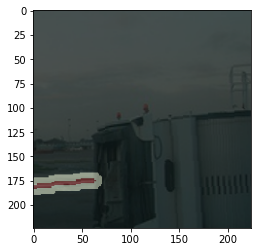

images size: torch.Size([3, 224, 224])
(array([  0,   1, 255], dtype=uint8), array([32569, 14914,  2693], dtype=int64))


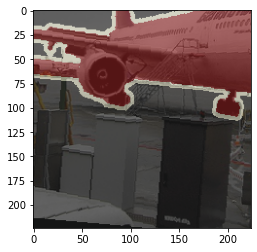

images size: torch.Size([3, 224, 224])
(array([  0,  19, 255], dtype=uint8), array([ 1831, 46003,  2342], dtype=int64))


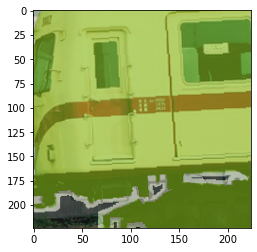

images size: torch.Size([3, 224, 224])
(array([  0,   4, 255], dtype=uint8), array([42640,  5656,  1880], dtype=int64))


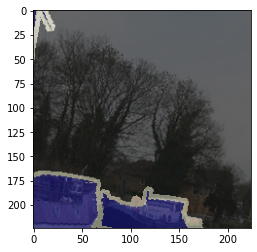

images size: torch.Size([3, 224, 224])
(array([  0,  15, 255], dtype=uint8), array([11680, 35035,  3461], dtype=int64))


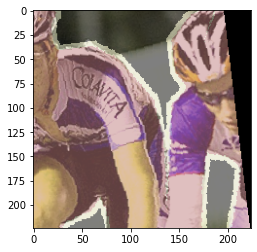

In [6]:
# Preview some train images:
n_preview = 5
for i in range(n_preview):
    image, mask = train_set[i]
    print('images size:', image.shape)
    mask_img = onehot2image(mask)
    image = inv_normalize(image)
    print(np.unique(mask_img, return_counts=True))
    preview(image, mask_img, 0.5)

images size: torch.Size([3, 224, 224])
(array([  0,  20, 255], dtype=uint8), array([21704, 26388,  2084], dtype=int64))


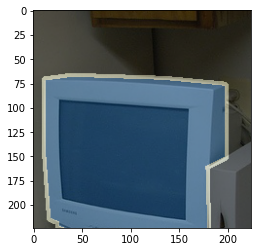

images size: torch.Size([3, 224, 224])
(array([  0,   9,  12, 255], dtype=uint8), array([14075, 21463, 12364,  2274], dtype=int64))


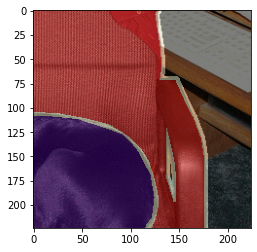

images size: torch.Size([3, 224, 224])
(array([  0,  20, 255], dtype=uint8), array([10402, 37451,  2323], dtype=int64))


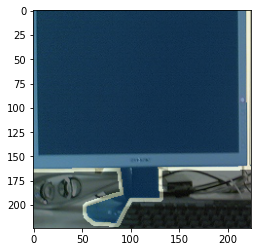

images size: torch.Size([3, 224, 224])
(array([  0,  19, 255], dtype=uint8), array([14554, 34051,  1571], dtype=int64))


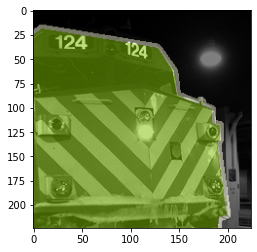

images size: torch.Size([3, 224, 224])
(array([  0,   5,  15, 255], dtype=uint8), array([17597,  1691, 28114,  2774], dtype=int64))


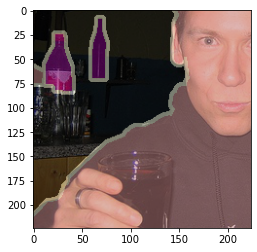

In [7]:
# Preview some val images:
n_preview = 5
for i in range(n_preview):
    image, mask = val_set[i]
    print('images size:', image.shape)
    mask_img = onehot2image(mask)
    image = inv_normalize(image)
    print(np.unique(mask_img, return_counts=True))
    preview(image, mask_img, 0.5)

images size: torch.Size([3, 352, 480])
(array([  0,  20, 255], dtype=uint8), array([135999,  30031,   2930], dtype=int64))


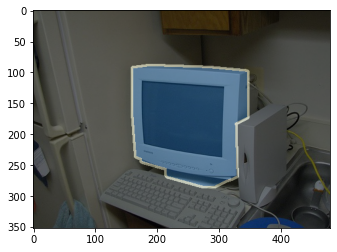

images size: torch.Size([3, 352, 480])
(array([  0,   9,  12, 255], dtype=uint8), array([57291, 76408, 27632,  7629], dtype=int64))


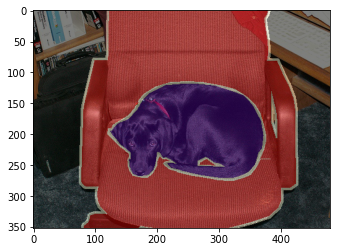

images size: torch.Size([3, 352, 480])
(array([  0,  20, 255], dtype=uint8), array([76800, 84493,  7667], dtype=int64))


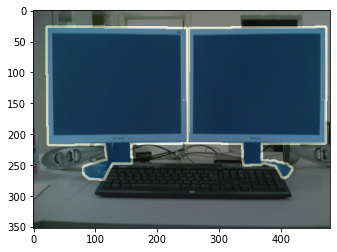

images size: torch.Size([3, 352, 480])
(array([  0,  19, 255], dtype=uint8), array([90634, 73727,  4599], dtype=int64))


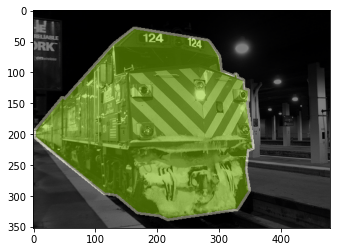

images size: torch.Size([3, 352, 480])
(array([  0,   5,  15, 255], dtype=uint8), array([85241,  2548, 74067,  7104], dtype=int64))


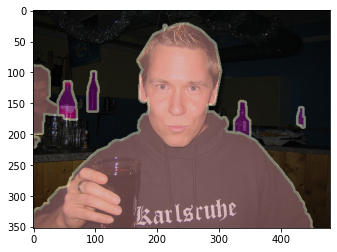

In [8]:
# Preview some tes images:
n_preview = 5
for i in range(n_preview):
    image, mask = test_set[i]
    print('images size:', image.shape)
    mask_img = onehot2image(mask)
    image = inv_normalize(image)
    print(np.unique(mask_img, return_counts=True))
    preview(image, mask_img, 0.5)

In [9]:
"""
def print_normalize_params(dataloader):
    '''
    Args: dataloader
    '''
    for ch in range(3):
        lst = []
        ct=0
        for i in range(len(dataloader)):
            image, _ = next(iter(dataloader))
            image = image[:,ch,:,:]
            image = torch.flatten(image)
            lst.append(image)
            ct+=1
        
        res = torch.cat(lst)
        print('channel:', ch, 'mean:', np.mean(res.numpy()), 'std:',np.std(res.numpy()), 'min:', np.min(res.numpy()), 'max:', np.max(res.numpy()))
    print(ct)

print_normalize_params(dataloader_train)
"""
'''
for VOC 2012
channel: 0 mean: 0.4590573 std: 0.27465963 min: 0.0 max: 1.0
channel: 1 mean: 0.44269726 std: 0.27202976 min: 0.0 max: 1.0
channel: 2 mean: 0.40997043 std: 0.28598067 min: 0.0 max: 1.0
'''

'\nfor VOC 2012\nchannel: 0 mean: 0.4590573 std: 0.27465963 min: 0.0 max: 1.0\nchannel: 1 mean: 0.44269726 std: 0.27202976 min: 0.0 max: 1.0\nchannel: 2 mean: 0.40997043 std: 0.28598067 min: 0.0 max: 1.0\n'

## TRAIN

In [10]:
##### UNET #####################################################

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

model_unet = UNet(22) 
summary(model_unet, input_size=(3, 224, 224)) # input size required to do the forward pass throught the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
####### RESNET ############################################

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )

class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=False)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

model_resnetunet = ResNetUNet(22)
summary(model_resnetunet, input_size=(3, 224, 224)) # input size required to do the forward pass throught the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [12]:
############ LOSS #########################################
#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

# https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)      
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()



def calc_loss(pred, target, metrics, bce_weight=0.5):
    
    bce = F.binary_cross_entropy_with_logits(pred, target)            
    
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)        
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))


########### TRAIN ##############################

def train(model, optimizer, scheduler, num_epochs=1):

    #Check device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device =',device)
    model=model.to(device)

    # Instantiate SummaryWriter
    writer = SummaryWriter()
    
    #Initialize some variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    lr = 0 #required so that learning rate prints first time   
    
    total_train_samples = 0
    total_test_samples=0

    # Iterate over epochs
    for epoch in tq.tqdm(range(num_epochs)):
        since = time.time()

        # print learning rate if it was changed in this epoch
        if lr != optimizer.param_groups[0]['lr']:
            lr = optimizer.param_groups[0]['lr']
            print("Learning rate =", lr)
        
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))            
        

        #Train----------------------      
        model.train()
        torch.set_grad_enabled(True)
       
        epoch_samples = 0
        metrics = defaultdict(float)     
        for batch_idx, (inputs, labels) in enumerate(dataloader_train):
            inputs = inputs.to(device, dtype=torch.float32)    
            labels = labels.to(device, dtype=torch.float32)
            
            batch_size = inputs.size(0)
            epoch_samples+=batch_size
            total_train_samples+=batch_size

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = calc_loss(outputs, labels, metrics)
           
            writer.add_scalar('train_loss', loss, total_train_samples)          

            loss.backward()
            optimizer.step()
        
        print_metrics(metrics, epoch_samples, 'train')

        #Eval------------------------
        epoch_samples = 0
        metrics = defaultdict(float)        
        if epoch % 3 == 0: # evaluate results for epochs ## n , e.g: 0, 10, 20...
            model.eval()
            torch.set_grad_enabled(False)
                #epoch_samples = 0
                #epoch_loss=0
            for batch_idx, (inputs, labels) in enumerate(dataloader_val):
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                batch_size = inputs.size(0)
                epoch_samples+=batch_size
                total_test_samples+=batch_size

                outputs = model(inputs)

                loss = calc_loss(outputs, labels, metrics)
                          
                writer.add_scalar('val_loss', loss, total_test_samples)     
                
            
            print_metrics(metrics, epoch_samples, 'val')
            epoch_loss = metrics['loss'] / epoch_samples 

            if epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'current_best_model_state_dict.pth')

            # preview last batch in tensorboard
            inputs = inputs.data.cpu()
            labels = labels.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()            
            for i in range(inputs.shape[0]):
                image = inputs[i,:,:,:]
                mask = labels[i,:,:,:]
                pred = outputs[i,:,:,:]

                image = inv_normalize(image) # implement inverse normalize to tensor
                image = transforms.ToPILImage()(image)

                mask = onehot2image(mask, mode='RGB')

                pred = onehot2image(pred, mode='RGB')  

                image_all = hstack_images((image, mask, pred))

                image_all = transforms.ToTensor()(image_all)

                writer.add_image('image', image_all, i)         

        # Step for learning rate scheduler
        scheduler.step()
    
    # Close SummaryWriter
    writer.close()
    
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [13]:
'''# UNET
# https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/24
# https://pytorch.org/docs/stable/nn.init.html
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

model = UNet(len(classes))
model=model.to(device)
model.apply(weights_init)
summary(model, input_size=(3, 224, 224)) # input size required to do the forward pass throught the model'''

"# UNET\n# https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/24\n# https://pytorch.org/docs/stable/nn.init.html\ndef weights_init(m):\n    if isinstance(m, nn.Conv2d):\n        #torch.nn.init.xavier_uniform_(m.weight)\n        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')\n        torch.nn.init.zeros_(m.bias)\n\nmodel = UNet(len(classes))\nmodel=model.to(device)\nmodel.apply(weights_init)\nsummary(model, input_size=(3, 224, 224)) # input size required to do the forward pass throught the model"

In [14]:
# RESNETUNET
num_classes = len(classes)
model = ResNetUNet(num_classes)
model=model.to(device)

#model.load_state_dict(torch.load('model_state_dict_018.pth', map_location=torch.device('cpu')))

model.load_state_dict(torch.load('current_best_model_state_dict.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
%%time

#%load_ext tensorboard
# !rm -rf runs # clean any previous data from tensorboard
#%tensorboard --logdir runs


optimizer = optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

model=train(model=model, optimizer=optimizer, scheduler=exp_lr_scheduler, num_epochs=6)

device = cpu


Learning rate = 0.001
----------
Epoch 0/5
train: bce: 0.194346, dice: 0.126395, loss: 0.160371
val: bce: 0.191525, dice: 0.134031, loss: 0.162778
saving best model
----------
Epoch 1/5
train: bce: 0.208268, dice: 0.127274, loss: 0.167771
----------
Epoch 2/5
train: bce: 0.204132, dice: 0.129955, loss: 0.167043
----------
Epoch 3/5
train: bce: 0.195579, dice: 0.127932, loss: 0.161755
val: bce: 0.189404, dice: 0.138745, loss: 0.164074
----------
Epoch 4/5
train: bce: 0.187172, dice: 0.133160, loss: 0.160166
----------
Epoch 5/5
train: bce: 0.193687, dice: 0.129199, loss: 0.161443

Best val loss: 0.162778
Wall time: 32min 31s


In [27]:
#torch.save(model.state_dict(), 'model_state_dict.pth')
#from google.colab import files
#files.download("model_state_dict.pth")

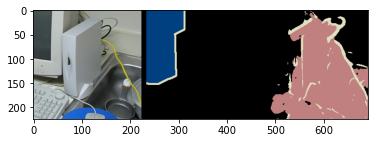

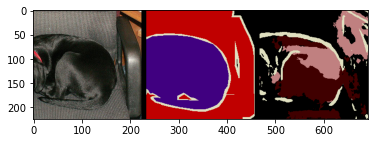

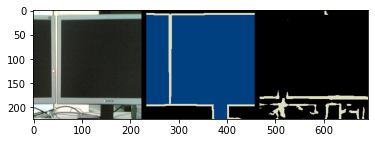

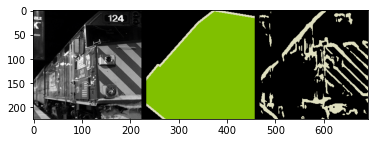

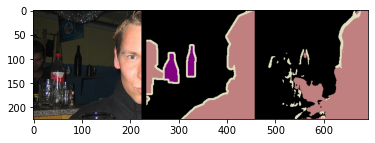

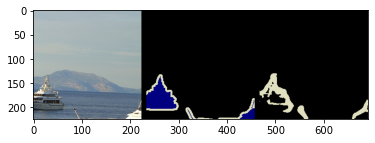

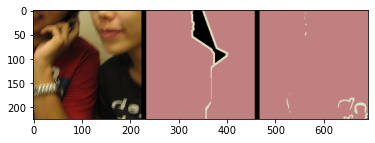

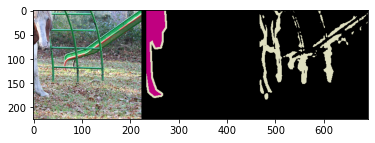

In [15]:
# Preview images masks and predictions from validation set
images, masks = next(iter(dataloader_val))

images = images.to(device)
model.eval()
torch.set_grad_enabled(False)
preds = model(images)

images = images.data.cpu()
masks = masks.data.cpu().numpy()
preds = preds.data.cpu().numpy()

for i in range(images.shape[0]):
  image = images[i,:,:,:]
  mask = masks[i,:,:,:]
  pred = preds[i,:,:,:]

  image = inv_normalize(image) # implement inverse normalize to tensor
  image = transforms.ToPILImage()(image)

  mask = onehot2image(mask, mode='RGB')

  pred = onehot2image(pred, mode='RGB')  

  image_all = hstack_images((image, mask, pred))

  plt.imshow(image_all)
  plt.show()

  #image_all = transforms.ToTensor()(image_all)
  #preview_tensor(image_all)  

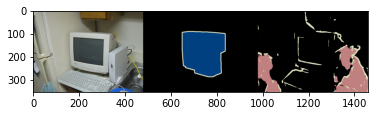

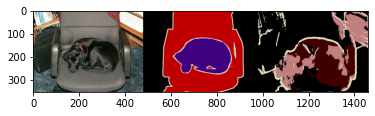

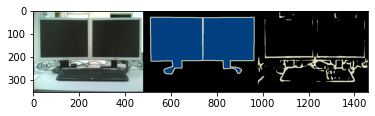

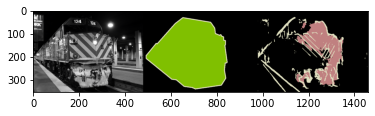

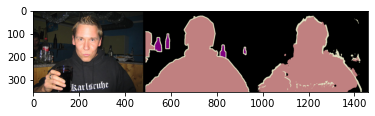

In [16]:
# Preview images masks and predictions from test set
n_preview = 5

# Preview some images from test set
iterator = iter(dataloader_test)
for i in range(n_preview):

    images, masks = next(iterator)

    images = images.to(device)
    model.eval()
    torch.set_grad_enabled(False)
    preds = model(images)

    images = images.data.cpu()
    masks = masks.data.cpu().numpy()
    preds = preds.data.cpu().numpy()

    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        mask = masks[i,:,:,:]
        pred = preds[i,:,:,:]

        image = inv_normalize(image) # implement inverse normalize to tensor
        image = transforms.ToPILImage()(image)

        mask = onehot2image(mask, mode='RGB')

        pred = onehot2image(pred, mode='RGB')  

        image_all = hstack_images((image, mask, pred))

        plt.imshow(image_all)
        plt.show()

original image size: (553, 563)
cropped image size: (544, 544)


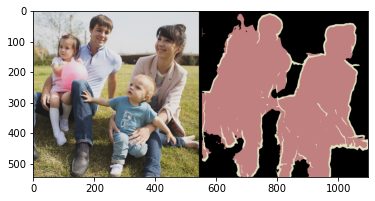

In [17]:
# Use custom image

test_image = Image.open('figures/0.jpg')
print('original image size:', test_image.size)
to_proper_size = ToProperSize(32)
test_image = to_proper_size(test_image)
print('cropped image size:', test_image.size)
plt.show()

test_image = transforms.ToTensor()(test_image)
test_image = normalize(test_image)
image = torch.unsqueeze(test_image, 0)
image = image.to(device)

model.eval()
torch.set_grad_enabled(False)
pred = model(image)

image = image.data.cpu()
pred = pred.data.cpu()

image = torch.squeeze(image)
pred = torch.squeeze(pred)

image = inv_normalize(image) # implement inverse normalize to tensor
image = transforms.ToPILImage()(image)

pred = pred.numpy()
pred = onehot2image(pred, mode='RGB')  

image_all = hstack_images((image, pred))

plt.imshow(image_all)
plt.show()